# Awair Amazon Review NLP

In [175]:
import pandas as pd # Data Processing
import matplotlib.pyplot as plt # Visualize
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from collections import Counter
from bs4 import BeautifulSoup
import re, requests
from wordcloud import WordCloud #NLP
from PIL import Image #Image import
import numpy as np

## Crawler

In [113]:
def review_crawl(div):
    review_text = div.find('div', 'a-row review-data').span.text
    review_stars = div.find('div', 'a-row').a.text
    
    return {
        "review_text" : review_text,
        "review_stars" : review_stars
    }

In [114]:
url = 'https://www.amazon.com/Awair-Whats-Breathe-Quality-Monitor/product-reviews/B011EFY014/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageSize=50&sortBy=recent&pageNumber='

In [115]:
# 리뷰의 갯수를 파악하여 크롤링 할 페이지 출력

soup = BeautifulSoup(requests.get(url + '1').text, 'lxml')
reviews_num = soup.find('span', attrs={'class':'a-size-medium totalReviewCount'}).text
pages = int(int(reviews_num)/50) + 1
print(pages)

6


In [116]:
# 페이지를 순회하며 남겨진 리뷰를 크롤링하고 그 개수를 출력

reviews = []
for page in range(1, pages + 1):
    print('crawling page:' , page, 'of', pages)
    tgt_url = url + str(page)
    soup = BeautifulSoup(requests.get(tgt_url).text, 'lxml')
    
    for div in soup('div', 'a-section review'):
        reviews.append(review_crawl(div))
print(len(reviews), 'reviews were collected')

crawling page: 1 of 6
crawling page: 2 of 6
crawling page: 3 of 6
crawling page: 4 of 6
crawling page: 5 of 6
crawling page: 6 of 6
262 reviews were collected


In [117]:
# 크롤링 된 리스트를 데이터프레임으로 변환

df = pd.DataFrame(reviews)
df.tail()

,review_stars,review_text
257,4.0 out of 5 stars,"Occasionally, I felt dizzy and tired when I am..."
258,4.0 out of 5 stars,I think it is useful to a person who has a pet.
259,4.0 out of 5 stars,After a few hiccups with support and logging i...
260,5.0 out of 5 stars,The Awair is the highest quality product I've ...
261,1.0 out of 5 stars,Android users do not buy as the app does not e...


In [118]:
df.isnull().sum()

review_stars    0
review_text     0
dtype: int64

## NLP
- 크롤링된 review를 기반으로 워드클라우드 생성하여 키워드 추출

In [129]:
# review_text.txt를 만들고 크롤링 된 review들을 해당 텍스트 파일에 저장

from os import path
reviews_text_filepath = 'data/reviews_text.txt'
with open(reviews_text_filepath, 'w') as f:
    for review in df.review_text.values:
        # if the row lacks a review, skip it.
        if pd.isnull(review):
            continue
        f.write(review + '\n')

In [130]:
def read_reviews(filepath):
    """
    helper function to read in the file and yield each line at a time.
    """
    with open(filepath) as f:
        for review in f:
            yield review

In [131]:
from itertools import islice
def retrieve_review(sample_num):
    """
    get a specific review from reviews text file and return it.
    """
    return next(islice(read_reviews(reviews_text_filepath), sample_num, sample_num+1))

In [132]:
# 200번째 리뷰를 불러와 확인

sample_review = retrieve_review(200)
sample_review

"Doesn't feel much value given the amount of money spent on this. Could have supported historical data for more than 1 day by sending to cloud storage if limited local storage was the reason for allowing only 1 day historical data.\n"

In [133]:
import spacy
# load english vocabulary and language models. This takes some time.
nlp = spacy.load('en')

In [134]:
def lemmatize(line):
    """
    remove punctuation and whitespace.
    """
    return [token.lemma_ for token in line 
                      if not token.is_punct and not token.is_space]

In [135]:
# 위에서 불러온 200번쨰 리뷰에 lemmatize 를 적용하여 동작확인

sample_review_normalized = lemmatize(nlp(sample_review))
' '.join(sample_review_normalized)

'do not feel much value give the amount of money spend on this could have support historical datum for more than 1 day by send to cloud storage if limited local storage be the reason for allow only 1 day historical datum'

In [136]:
# 모든 review data에 lemmatize를 적용하고, Stop words를 불러와 필요없는 내용을 삭제

sentences_normalized_filepath = 'data/sentences_normalized.txt'

with open(sentences_normalized_filepath, 'w') as f:
        for review_parsed in nlp.pipe(read_reviews(reviews_text_filepath)):
            for sentence_parsed in review_parsed.sents:
                lemmas = lemmatize(sentence_parsed)
                lemmas = [lemma for lemma in lemmas 
                              if lemma not in spacy.en.STOP_WORDS and lemma != '-PRON-']
                f.write(' '.join(lemmas) + '\n')

In [181]:
total_normal = open('data/sentences_normalized.txt').read()
#total_normal = re.sub(r"(?<=[a-z])\r?\n"," ", total_normal)
#total_normal = total_normal.split(' ')

In [194]:
# 마스킹 할 이미지 import

awair_mask = Image.open("data/awair.png").convert("RGBA")
mask = Image.new("RGB", awair_mask.size, (255,255,255))
mask.paste(awair_mask,awair_mask)
mask = np.array(mask)
text = 'data/sentences_normalized.txt'

In [195]:
stopwords = spacy.en.STOP_WORDS
wc = WordCloud(background_color="white", max_words=3000,
              mask=mask, stopwords=stopwords)
wc = wc.generate_from_text(total_normal)
wc.to_file("test.png")

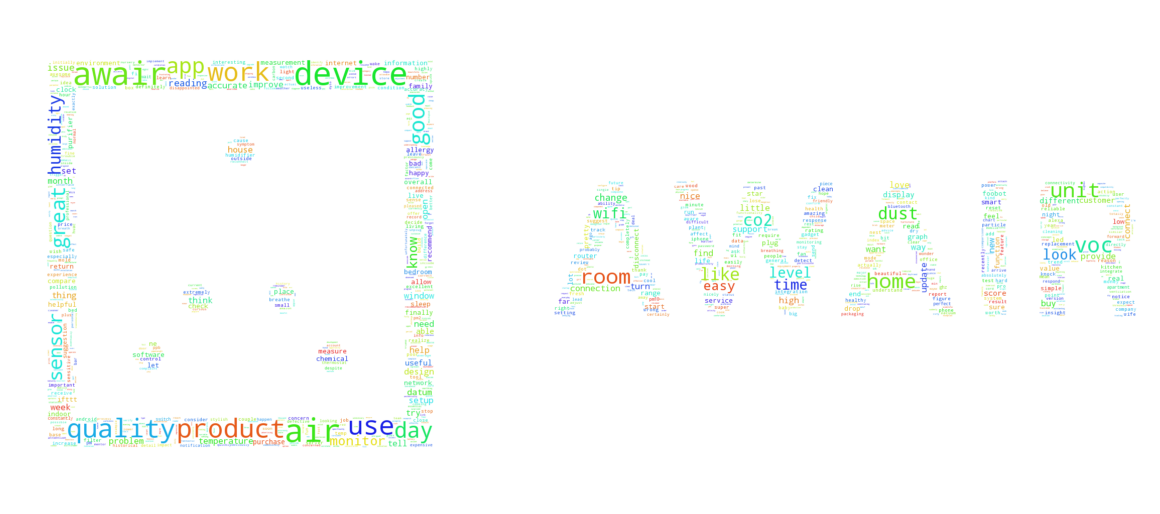

In [198]:
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

- 많이 언급되는 단어들을 기반으로 Awair 로고에 워드클라우드 생성
- but, 긍정/부정 리뷰를 동시에 적용한 탓에 유의미한 정보를 얻어내기 어려움
- 차후 진행해보면 좋을 프로세스
    - 긍정/부정을 나타내는 column을 추가하여 TF-IDF를 적용
        - 제품명인 awair와 같은, 긍정/부정에 영향을 미치지 않는 단어를 제거할 수 있음
    - TF-IDF 결과를 바탕으로 긍정/부정 review를 분리하여 워드클라우드를 적용
        - 감정마다 어떤 단어가 더 많이 등장하는지 확인할 수 있음
        - 긍정에 나타나는 단어는 장점으로 부각하고, 부정에 나타나는 단어는 보완해야 할 것으로 판단 가능
    - 리뷰 개수가 200여 개기에 다른 쇼핑몰에서 데이터를 더 추가해야 할 필요성